In [129]:
import statsmodels.graphics.tsaplots as sgt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
import pandas as pd
import investpy
from arch import arch_model
import pylab 

In [59]:
index = investpy.get_index_historical_data(index='Bovespa', country='brazil', from_date='01/01/1990', to_date='13/05/2021')

In [60]:
copy = index.copy()['Close']

In [61]:
index = index.reset_index()[['Date','Close']]

In [62]:
index['Returns'] = index['Close'].pct_change() * 100

In [63]:
index['ret_vol'] = index['Returns'].map(lambda x: abs(x))

Text(0.5, 1.0, 'Volativity')

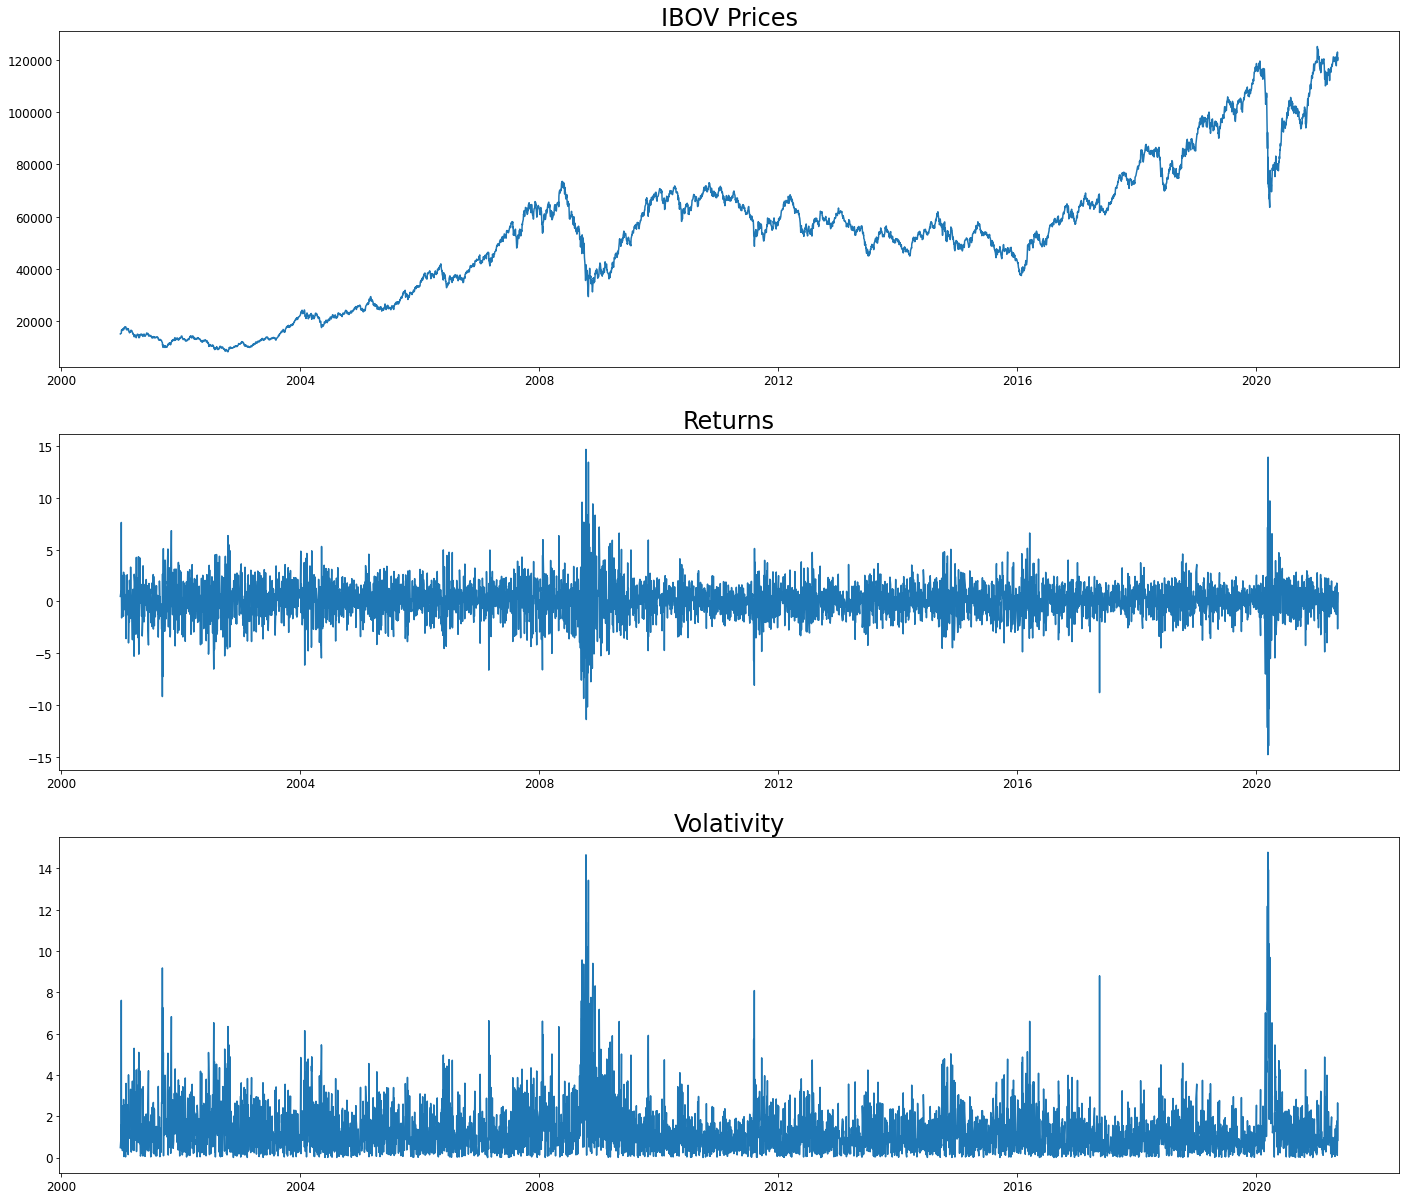

In [115]:
plt.rcParams["figure.figsize"] = 24, 21
fig, axes = plt.subplots(3, 1)

axes[0].plot(index.Date,index.Close)
axes[0].set_title("IBOV Prices", size = 24)

axes[1].plot(index.Date, index.Returns)
axes[1].set_title("Returns", size = 24)

axes[2].plot(index.Date, index.ret_vol)
axes[2].set_title("Volativity", size = 24)

In [65]:
index["Year"] = index.set_index('Date').index.year

Text(0.5, 1.0, 'Boxplot for Volativity')

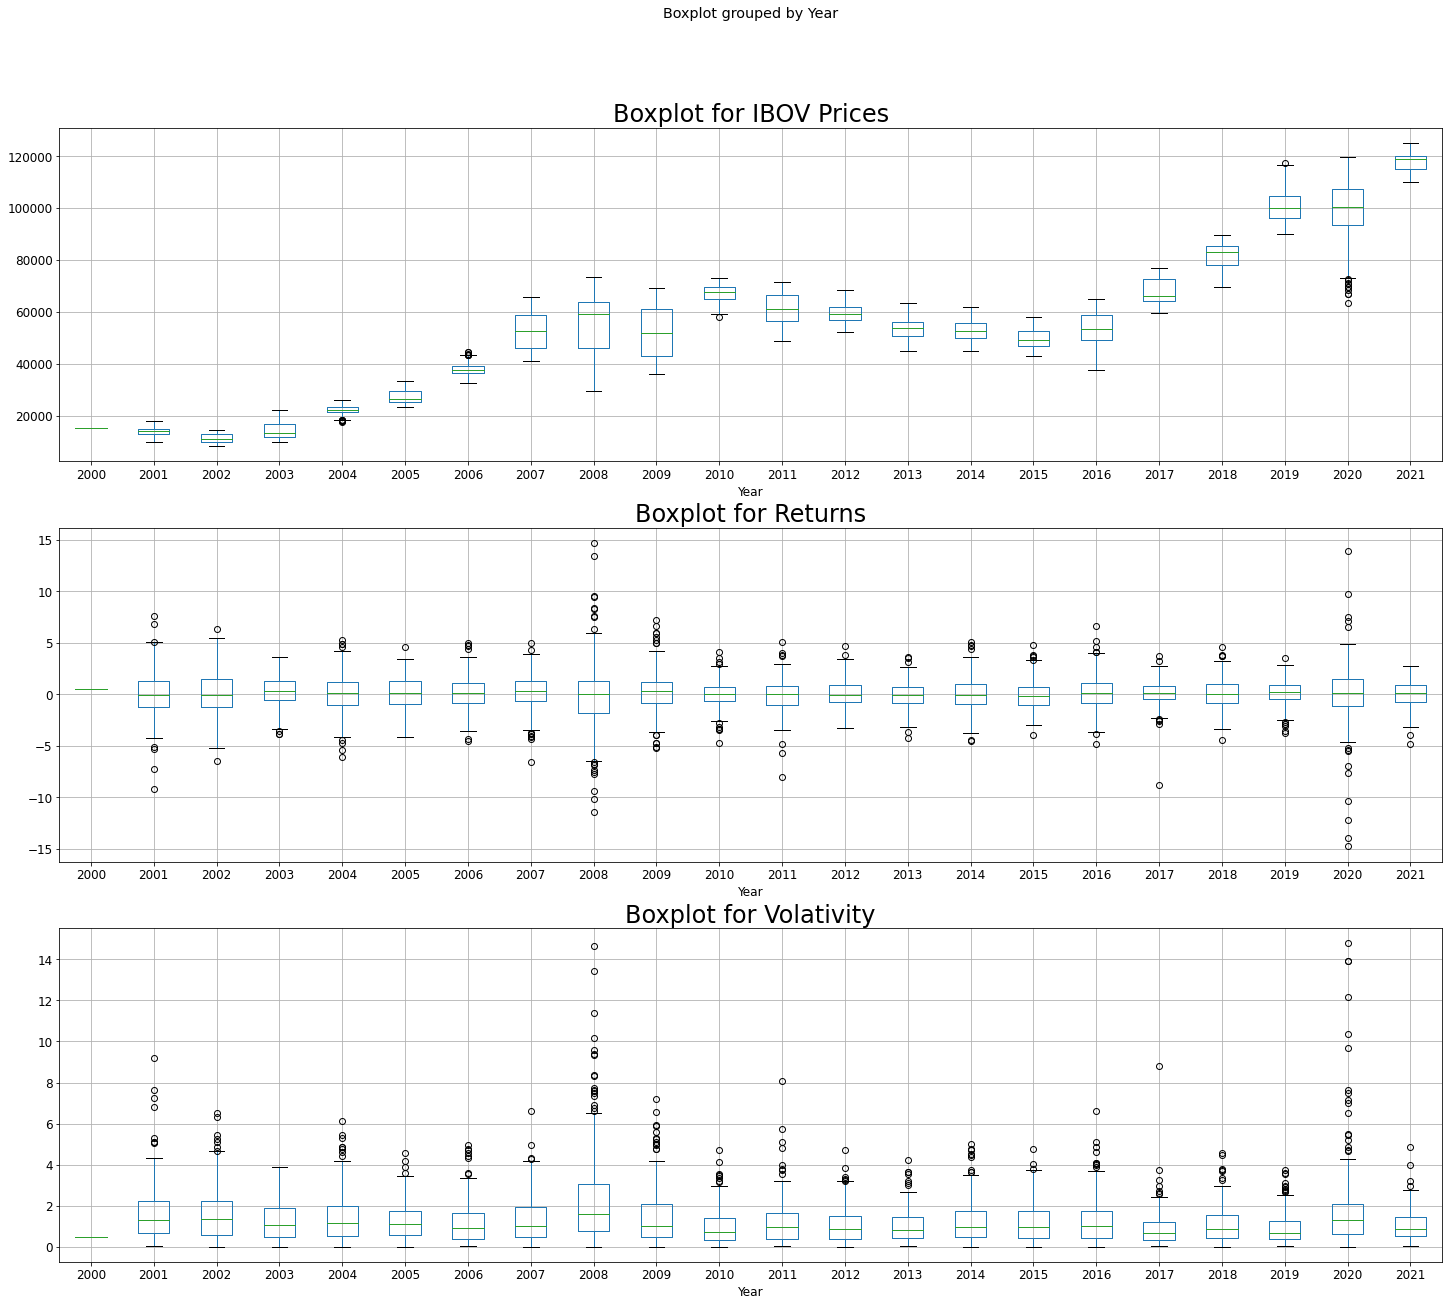

In [109]:
plt.rcParams["figure.figsize"] = 24, 21
fig, axes = plt.subplots(3, 1)

# Second Boxplot: Yearly IBOV yearly
index.boxplot(by ='Year', column =['Close'], ax = axes[0])
axes[0].set_title("Boxplot for IBOV Prices", size = 24)

# Second Boxplot: Yearly IBOV Returns
index.boxplot(by ='Year', column =['Returns'], ax = axes[1])
axes[1].set_title("Boxplot for Returns", size = 24)

# Third Boxplot: Yearly IBOV Volatility
index.boxplot(by ='Year', column =['ret_vol'], ax = axes[2])
axes[2].set_title("Boxplot for Volativity", size = 24)

Text(0.5, 1.0, 'Partial Autocorrelation for IBOV Volatility')

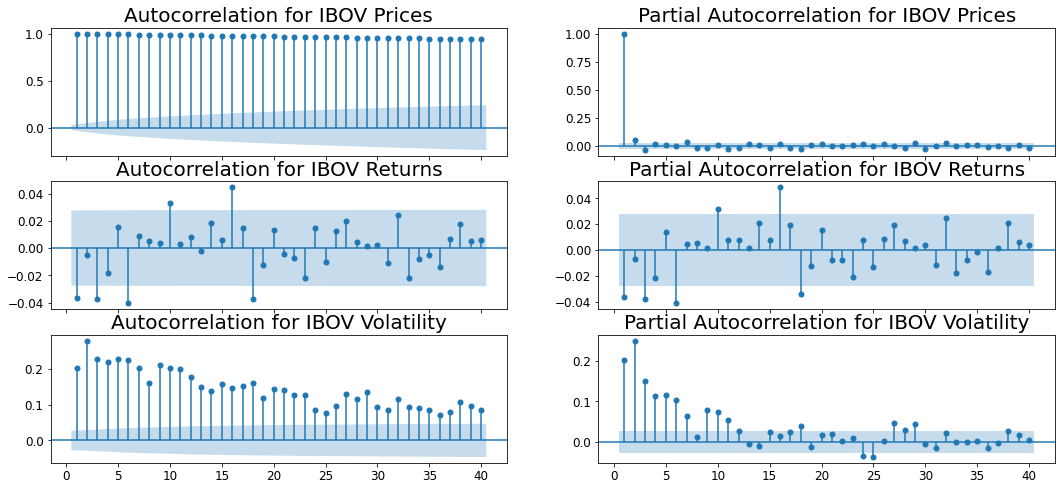

In [108]:
plt.rcParams["figure.figsize"] = 18, 8

# Defining the subplots with shared x-axis
fig, axes = plt.subplots(3, 2, sharex = True)

sgt.plot_acf(index.Close, zero = False, lags = 40, ax = axes[0, 0])
sgt.plot_acf(index.Returns[1:], zero = False, lags = 40, ax = axes[1, 0])
sgt.plot_acf(index.ret_vol[1:], zero = False, lags = 40, ax = axes[2, 0])

axes[0, 0].set_title("Autocorrelation for IBOV Prices", size = 20)
axes[1, 0].set_title("Autocorrelation for IBOV Returns", size = 20)
axes[2, 0].set_title("Autocorrelation for IBOV Volatility", size = 20)

sgt.plot_pacf(index.Close, zero = False, lags = 40, ax = axes[0, 1])
sgt.plot_pacf(index.Returns[1:], zero = False, lags = 40, ax = axes[1, 1])
sgt.plot_pacf(index.ret_vol[1:], zero = False, lags = 40, ax = axes[2, 1])

axes[0, 1].set_title("Partial Autocorrelation for IBOV Prices", size = 20)
axes[1, 1].set_title("Partial Autocorrelation for IBOV Returns", size = 20)
axes[2, 1].set_title("Partial Autocorrelation for IBOV Volatility", size = 20)

In [67]:
copy = copy.pct_change().dropna() * 100

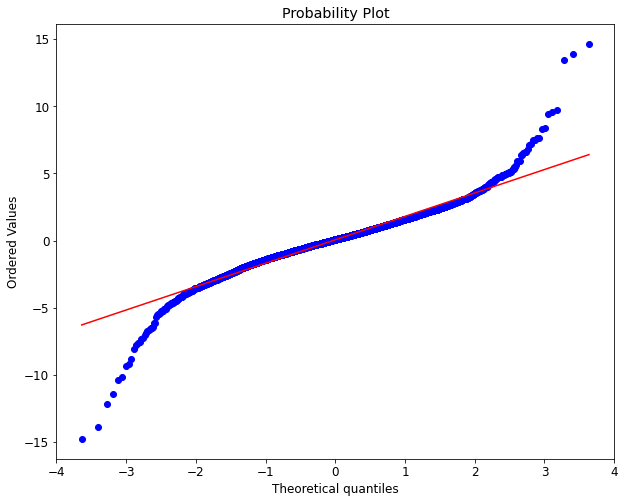

In [120]:
plt.rcParams["figure.figsize"] = 10, 8
stats.probplot(copy.reset_index()['Close'], dist="norm", plot=pylab)
pylab.show()

In [37]:
X = copy.reset_index()['Close']

In [38]:
from sklearn.model_selection import TimeSeriesSplit

In [39]:
tscv = TimeSeriesSplit()

In [40]:
for train_index, test_index in tscv.split(X):
    train_df, test_df = X[train_index], X[test_index]

In [42]:
model = sm.tsa.statespace.SARIMAX(train_df, order = (1, 0, 1))
# Fitting the Model
model_results = model.fit()

# Printing the model summary
print(model_results.summary())

c:\users\luisf\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\luisf\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4201
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -8378.662
Date:                Mon, 17 May 2021   AIC                          16763.323
Time:                        12:27:11   BIC                          16782.352
Sample:                             0   HQIC                         16770.052
                               - 4201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002     24.857   7.51e-06      1.000     -48.718      48.718
ma.L1          0.0002     24.858    7.2e-06      1.000     -48.721      48.721
sigma2         3.1614      0.040     78.411      0.0

In [43]:
arma_forecast = model_results.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)

In [44]:
arma_predictions_df["Predictions"] = model_results.predict(start = test_df.index[0], end = test_df.index[-1])

In [45]:
arma_rmse = np.sqrt(mean_squared_error(test_df.values, arma_predictions_df["Predictions"]))

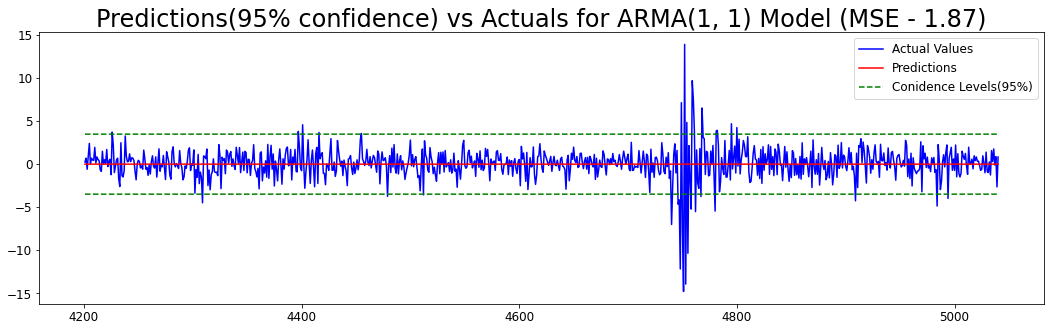

In [59]:
plt.rcParams["figure.figsize"] = 18, 5

# Plot the Actuals
plt.plot(test_df, color = "blue", label = "Actual Values")

# Plot the Forecasts and the Confidence Intervals 
plt.plot(arma_predictions_df["Predictions"][test_df.index], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper Close"][test_df.index], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(arma_predictions_df["lower Close"][test_df.index], color = "green", linestyle = "--")

# Set the Title of the Plot
plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(1, 1) Model (MSE - {round(arma_rmse, 2)})", size = 24)

# Display the plot with appropriate labels
plt.legend()
plt.show()

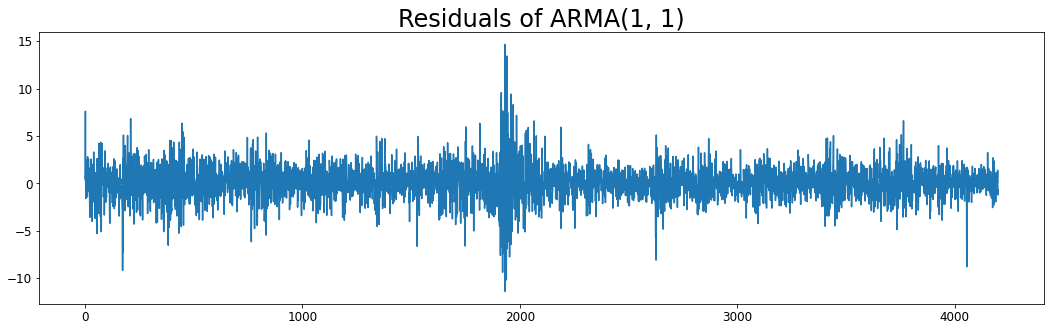

In [60]:
plt.rcParams["figure.figsize"] = 18, 5

# Plotting residuals
plt.plot(model_results.resid, label = "Residuals")

# Setting Title
plt.title("Residuals of ARMA(1, 1)", size = 24)

# Display the plot
plt.show()

In [102]:
resid_df = X.copy()
resid_df = pd.DataFrame(resid_df)
resid_df["returns_resid"] = resid_df.shift(1).loc[resid_df.index]

In [103]:
resid_df.at[train_df.index[1]:train_df.index[-1], "returns_resid"] = model_results.resid

In [137]:
resid_model = arch_model(model_results.resid, p = 2, q = 2, vol = "GARCH")

In [138]:
resid_model_results = resid_model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     48,   Neg. LLF: 8027.256932040644
Iteration:     10,   Func. Count:     88,   Neg. LLF: 7979.3183525429595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7979.318033103271
            Iterations: 14
            Function evaluations: 115
            Gradient evaluations: 14


In [143]:
resid_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7979.32
Distribution:                  Normal   AIC:                           15970.6
Method:            Maximum Likelihood   BIC:                           16008.7
                                        No. Observations:                 4201
Date:                Mon, May 17 2021   Df Residuals:                     4200
Time:                        13:12:40   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0756  2.389e-02      3.163  1.561e-03 [2.874e-02,  0.122]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1039  3.212e-02      3.233  1.223e-03    [4.091e-02,  0.167]
alpha[1]       0.0267  1.577e-02      1.696  8.992e-02 [-4.165e-03,5.765e-02]
alpha[2]       0.0817  2.011e-02      4.060  4.900e-05    [4.224e-02,  0.121]
beta[1]        0.3725      0.188      1.983  4.732e-02    [4.403e-03,  0.741]
beta[2]        0.4831      0.174      2.771  5.593e-03      [  0.141,  0.825]
=============================================================================

Covariance estimator: robust
"""

Figure(1296x360)


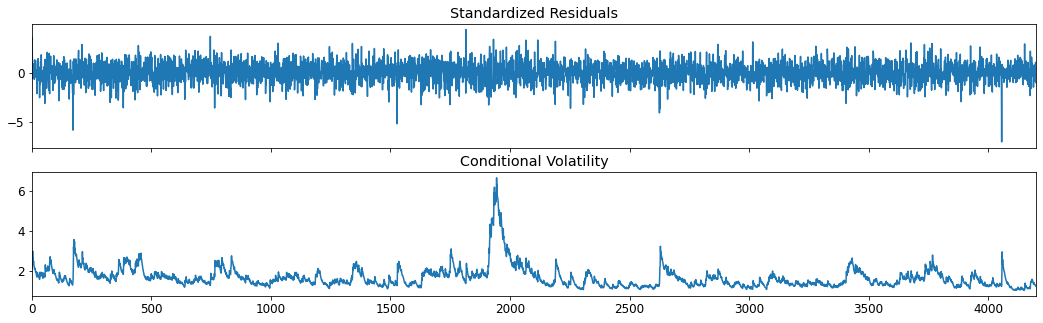

In [166]:
print(resid_model_results.plot())

References:

Towards AI. Statistical Forecasting for Time Series Data Part 5: ARMA+GARCH model for Time Series Forecasting (2020), https://towardsai.net/p/data-visualization/statistical-forecasting-for-time-series-data-part-5-armagarch-model-for-time-series-forecasting

F. F. Val, A. C. F. Pinto, M. C. Klotzle. Volatility and Return Forecasting with High-Frequency and GARCH 
Models: Evidence for the Brazilian Market (2014), R. Cont. Fin. – USP, São Paulo, v. 25, n. 65, p. 189-201, maio/2014 https://www.scielo.br/pdf/rcf/v25n65/en_1519-7077-rcf-25-65-0189.pdf